<a href="https://colab.research.google.com/github/JunHyeong-data/ML-DL-Study/blob/main/Basic-Deep-Learning/05_%EB%94%A5%EB%9F%AC%EB%8B%9D_classification%2C_classifier_loss_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

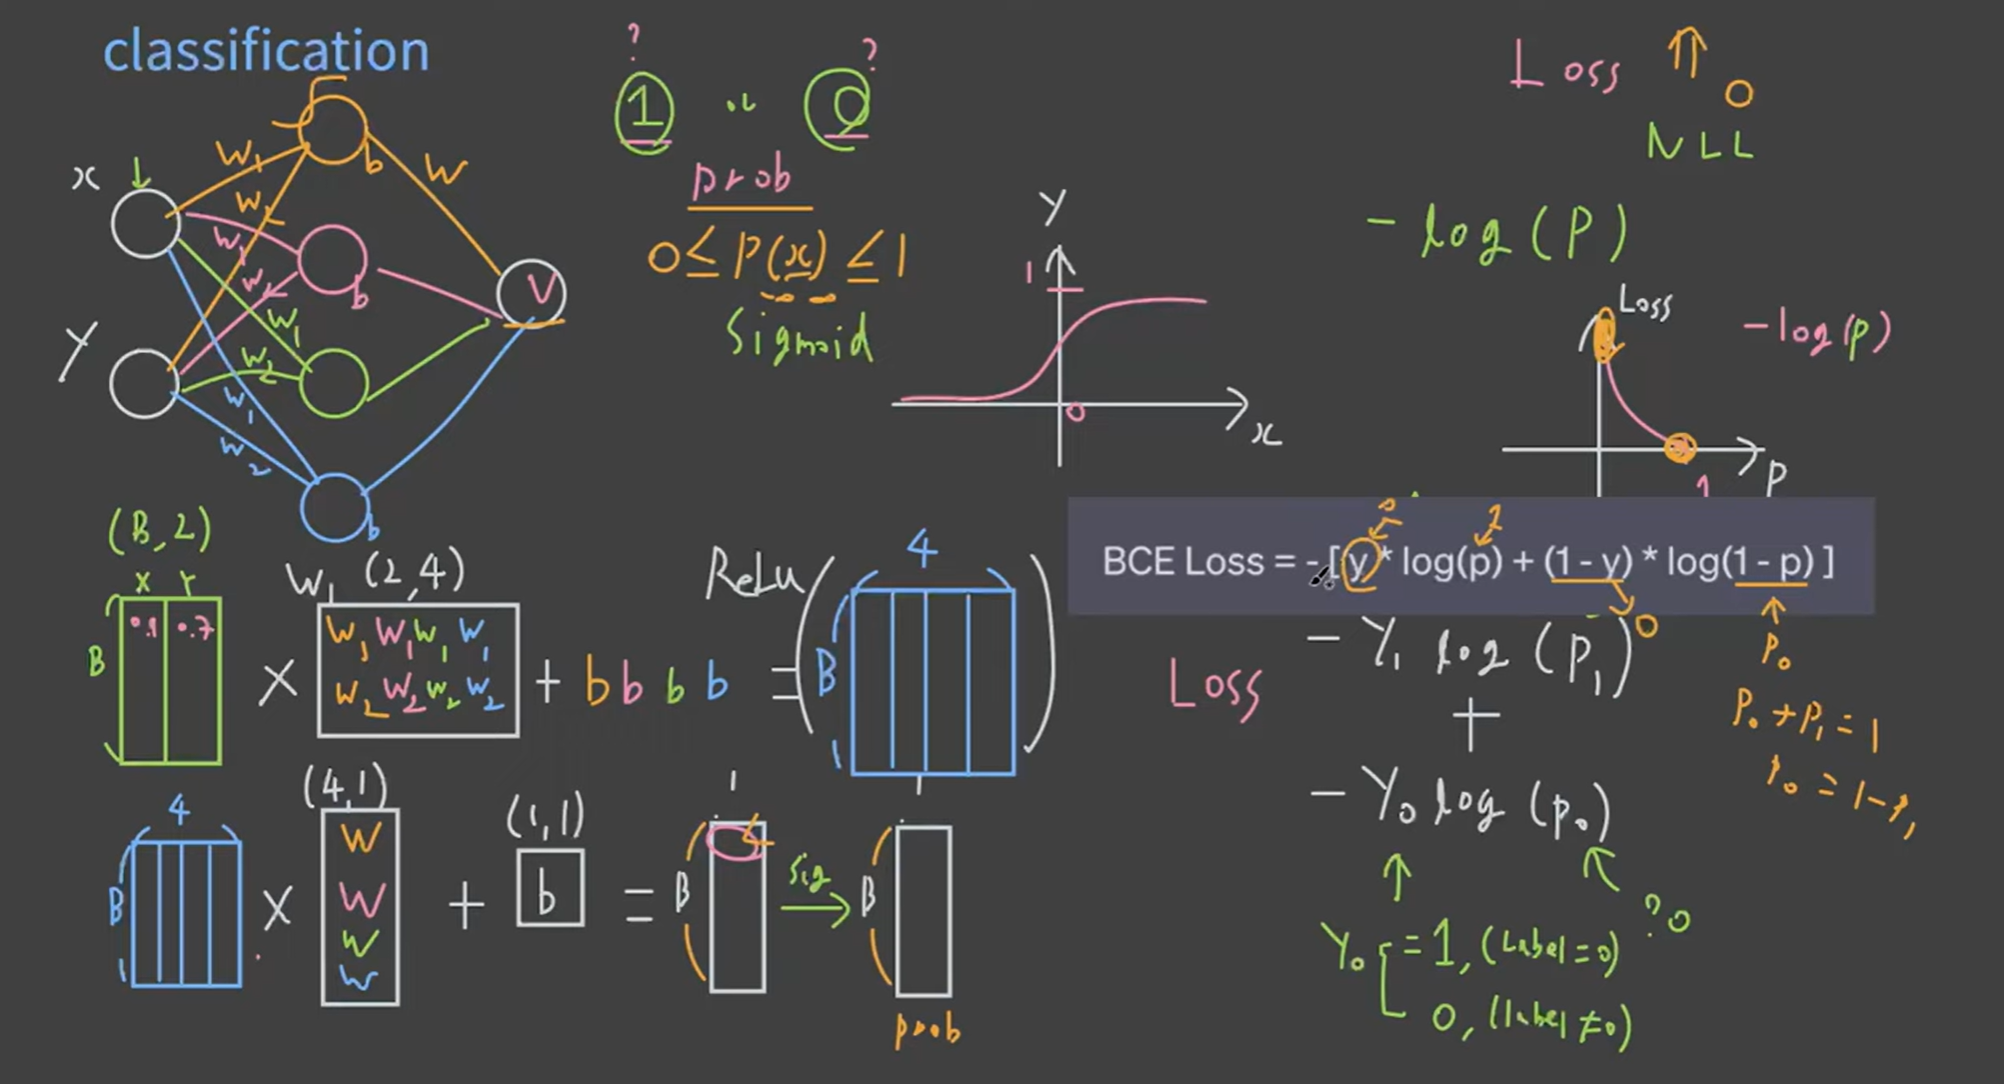
# Neural Network Classification with Perceptron (PyTorch)

## 1. Regression에서 Classification으로

이전 시간까지는 주어진 데이터에 가장 잘 맞는 직선을 찾는 **Regression 문제**를 다뤘다.  
이번 시간부터는 딥러닝에서 매우 중요한 **Classification 문제**를 다룬다.

Classification 문제 역시 Regression과 본질적으로 크게 다르지 않다.

- 네트워크를 정의하고
- Loss 함수를 설정한 뒤
- 최적화 과정을 통해 파라미터를 학습한다

이번에는 **퍼셉트론 기반 Neural Network**를 사용해 처음으로 Classification 문제를 풀어본다.

---

## 2. 데이터 소개

사용할 데이터는 다음과 같다.

- 입력 데이터: `(x, y)`
- 레이블: `0 또는 1`
- 전체 데이터 개수: `5000개`

CSV 파일 형태로 제공되며,  
Jupyter Notebook에서 다운로드한 뒤 Pandas로 불러온다.

```python
import pandas as pd
df = pd.read_csv("data.csv")
````

---

## 3. 데이터 시각화

데이터를 matplotlib으로 시각화하면
원점(0,0)을 중심으로 **원 형태의 분포**가 나타난다.

이 데이터를 Neural Network를 통해 분류하는 것이 목표이다.

---

## 4. Train / Validation Split & Batch 학습

전체 데이터를 다음과 같이 나눈다.

* Training Data
* Validation Data

딥러닝의 표준 방식인 **Batch 학습**을 사용하기 위해
Batch를 생성하는 helper function을 만든다.

이 과정은 이전 Regression 실습과 거의 동일하다.

---

## 5. Neural Network 구조

이번에 구현할 Neural Network는 다음 구조를 가진다.

* Input Layer: 2 (x, y)
* Hidden Layer: 4 neurons
* Output Layer: 1 neuron

즉,

```
(2) → (4) → (1)
```

---

## 6. Input Matrix 형태

Batch Size를 `B`라고 하면,

* Input Matrix Shape: `(B, 2)`
* Label Shape: `(B, 1)`

즉, 한 번에 `B`개의 `(x, y)` 데이터가 네트워크로 들어온다.

---

## 7. 첫 번째 Hidden Layer 연산

### Weight & Bias

* Weight Matrix `W1`: `(2, 4)`
* Bias `b1`: `(4,)`

### 연산 과정

```text
Z1 = X · W1 + b1
```

* `X`: `(B, 2)`
* 결과 `Z1`: `(B, 4)`

Bias는 브로드캐스팅되어 각 행에 더해진다.

---

## 8. Activation Function

Hidden Layer 출력에 **ReLU**를 적용한다.

```text
A1 = ReLU(Z1)
```

* Shape 변화 없음
* `(B, 4)`

---

## 9. Output Layer 연산

### Weight & Bias

* Weight Matrix `W2`: `(4, 1)`
* Bias `b2`: `(1,)`

### 연산 과정

```text
Output = A1 · W2 + b2
```

* 결과 Shape: `(B, 1)`

즉, 배치 사이즈만큼의 row와
하나의 column을 가진 최종 output이 생성된다.

---

## 10. PyTorch 구현 개요

전체 연산 흐름은 다음과 같다.

```python
# Forward Pass
Z1 = X @ W1 + b1
A1 = relu(Z1)
Output = A1 @ W2 + b2
```

Output의 Shape을 출력해보면,

```
(batch_size, 1)
```

으로 예상과 정확히 일치한다.

---

## 11. 왜 직접 구현하는가?

PyTorch에는 `nn.Linear`, `nn.Sequential` 같은 편리한 함수들이 있다.
하지만 **처음 한 번은 직접 구현해봐야 한다.**

그 이유는 다음과 같다.

* Matrix Dimension 감각을 익히기 위해
* Batch 개념을 정확히 이해하기 위해
* 이후 배울

  * Convolution Layer
  * Transformer Architecture
    를 이해하는 데 큰 도움이 되기 때문

---

## 12. 핵심 정리

이번 실습에서 가장 중요한 포인트는 다음이다.

* Neural Network의 모든 연산은 **Matrix로 표현 가능**
* Forward Pass는 결국 **Matrix Multiplication의 연속**
* 최종 Output Shape은
  **(Batch Size, 1)**

---

## 13. 다음 단계

현재 우리는 Neural Network의 **Output까지** 만들었다.
하지만 아직 이 Output으로부터 **Loss를 계산하는 방법**을 배우지 않았다.

다음 시간에는,

* Output → Loss 계산
* Classification Loss (Binary Cross Entropy)
* 학습 과정 전체 흐름

을 다룬다.



# Neural Network Classification (2)
## Sigmoid, Binary Cross Entropy Loss, Backpropagation

---

## 1. 이전 내용 요약

이전 시간에는 Neural Network를 직접 구현하여  
**Input Batch Matrix → Hidden Layer → Output** 까지 계산했다.

- Input Shape: `(B, 2)`
- Hidden Layer: 4 neurons
- Output Shape: `(B, 1)`

이번 시간에는 이 **최종 Output으로부터 Loss를 계산하고**,  
**Backpropagation을 통해 파라미터를 최적화**한다.

---

## 2. 코드 리팩토링

기존 코드를 가독성 좋게 정리한다.

- Input size: `2 (x, y)`
- Hidden size: `4`
- Output size: `1`
- Random seed 고정 (재현성 확보)
- Label batch도 함께 사용

이제 Neural Network의 output에서 **loss까지 계산**할 준비가 끝났다.

---

## 3. Classification에서 필요한 것

우리가 풀고자 하는 문제는 다음과 같다.

- 입력 `(x, y)`가 주어졌을 때
- 레이블이 `0`인지 `1`인지 예측

Neural Network의 output은 **실수값**이며  
이 값은 `-∞ ~ +∞` 범위를 가질 수 있다.

하지만 Classification에서는  
**0일 확률 / 1일 확률**이 필요하다.

---

## 4. Sigmoid Function

이를 위해 사용하는 함수가 **Sigmoid 함수**이다.

Sigmoid 함수의 특징:

- 입력: `(-∞ ~ +∞)`
- 출력: `(0 ~ 1)`
- 확률값으로 해석 가능

수학적 정의는 다음과 같지만, 외울 필요는 없다.

```text
σ(x) = 1 / (1 + e^(-x))
````

중요한 점은
**Neural Network의 output을 확률값으로 변환**할 수 있다는 것이다.

---

## 5. Loss란 무엇인가?

Loss는 예측이 틀렸을 때 주는 **Penalty**이다.

* 예측이 맞으면 → Loss 작음
* 예측이 틀리면 → Loss 큼

확률값을 기반으로 한 Classification에서는
**Negative Log Likelihood**를 많이 사용한다.

---

## 6. Negative Log Likelihood

확률 `p (0~1)`에 대해 다음을 적용한다.

```text
Loss = -log(p)
```

이 함수의 성질:

* `p = 1` → Loss = 0
* `p → 0` → Loss → ∞

즉,

* 정답을 확신하면 Loss는 작고
* 틀린 예측을 하면 큰 Loss를 받는다

Classification에 매우 적합한 Loss 함수이다.

---

## 7. Binary Classification Loss

레이블이 `0` 또는 `1`인 경우를 생각해보자.

* `y = 1`일 때 → `p1` (1일 확률)
* `y = 0`일 때 → `p0` (0일 확률)

이를 하나의 수식으로 정리하면 다음과 같다.

```text
Loss = -[ y·log(p) + (1-y)·log(1-p) ]
```

이 식이 바로 **Binary Cross Entropy Loss**이다.

인터넷에서 흔히 보는 Binary Classifier Loss 수식과 동일하다.

---

## 8. Loss 계산 코드 개념

Neural Network의 output에 대해 다음을 수행한다.

1. Sigmoid 적용 → 확률 변환
2. Binary Cross Entropy Loss 계산
3. Batch 단위 평균

```python
prob = sigmoid(output)
loss = -(y * torch.log(prob) + (1 - y) * torch.log(1 - prob))
loss = loss.mean()
```

이 결과는 **하나의 scalar 값**이다.

---

## 9. Training Loop & Backpropagation

이제 Loss를 최소화하기 위해 학습을 진행한다.

* 파라미터: `W1, b1, W2, b2`
* Learning Rate: `0.01`
* Backpropagation으로 gradient 계산
* Gradient만큼 파라미터 업데이트
* Gradient 초기화

```text
loss.backward()
W -= lr * W.grad
W.grad.zero_()
```

---

## 10. Validation Loss 확인

학습이 잘 되고 있는지 확인하기 위해
매 1000 step마다 validation loss를 계산한다.

학습이 정상적으로 진행되면
**Validation Loss가 점점 감소**한다.

---

## 11. 학습 결과 시각화

학습이 끝난 Neural Network를 이용해 결과를 시각화한다.

* `-1 ~ 1` 구간에 10만 개의 포인트 생성
* Forward Pass 수행
* Sigmoid로 확률 변환
* 확률 `> 0.5` → class 1
* 확률 `≤ 0.5` → class 0

이를 matplotlib으로 그리면:

* 중심부: 한 클래스
* 바깥 영역: 다른 클래스

깔끔하게 분류된 결과를 확인할 수 있다.

---

## 12. Threshold의 의미

기본 Threshold는 `0.5`를 사용했다.

하지만 이는 변경 가능하다.

* `0.3`, `0.8` 등으로 조절 가능
* Recall / Precision Trade-off 발생

이는 Machine Learning 이론 영역이므로
추후 다른 챕터에서 다룬다.

---

## 13. 이번 시간 핵심 정리

이번 예제에서 직접 구현한 것:

* Batch Matrix 생성
* Matrix Multiplication 기반 Neural Network
* Sigmoid를 이용한 확률 변환
* Binary Cross Entropy Loss 계산

PyTorch가 도와준 것은 **Backpropagation 계산뿐**이다.

---

## 14. 왜 이렇게 직접 구현하는가?

이 과정을 직접 해보면:

* 2D, 3D Tensor 흐름을 머릿속에 그릴 수 있고
* Convolution Layer
* Transformer Architecture

를 훨씬 쉽게 이해할 수 있다.

---

In [1]:
!git clone https://github.com/NoCodeProgram/deepLearning.git

Cloning into 'deepLearning'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 318 (delta 80), reused 134 (delta 55), pack-reused 139 (from 1)
Receiving objects: 100% (318/318), 17.60 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
import torch
import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('./deepLearning/nn/classify5k.csv')

# Convert the DataFrame to a numpy array
data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

# Print the shapes of the data and labels
print(f'Data shape:{data.shape}')
print(f'Labels shape:{labels.shape}')

Data shape:(5000, 2)
Labels shape:(5000, 1)


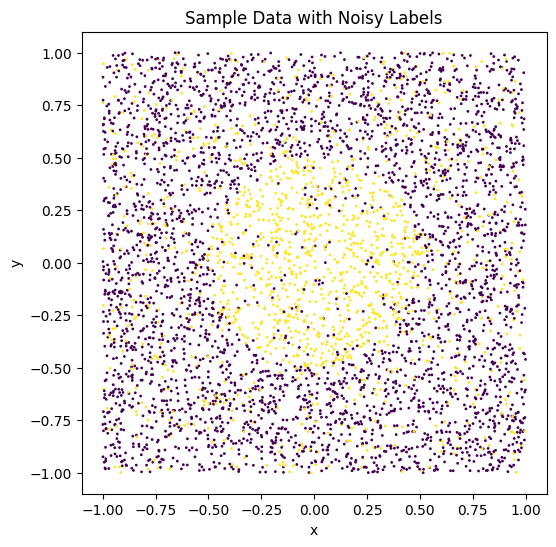

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=1)
plt.title('Sample Data with Noisy Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)
data_length = len(data_torch)
split_length = int(0.8*data_length)

train_data = data_torch[:split_length]
train_labels = labels_torch[:split_length]
val_data = data_torch[split_length:]
val_labels = labels_torch[split_length:]

print(train_data.shape)
print(train_labels.shape)

torch.Size([4000, 2])
torch.Size([4000, 1])


In [8]:
from numpy import indices
g = torch.Generator().manual_seed(42)

def get_batch(data, labels, batch_size=256):
  indices = torch.randint(low=0, high=len(data), size=(batch_size,), generator=g)

  data_batch = data[indices]
  labels_batch = labels[indices]
  return data_batch, labels_batch

data_batch, labels_batch = get_batch(train_data, train_labels)
print(data_batch.shape)
print(labels_batch.shape)
"""이 코드는 전체 학습 데이터에서 랜덤 인덱스를 이용해 미니배치(256개)를 뽑아 반환하는 함수이며, SGD 학습을 위한 핵심 구성요소다."""

torch.Size([256, 2])
torch.Size([256, 1])


'이 코드는 전체 학습 데이터에서 랜덤 인덱스를 이용해 미니배치(256개)를 뽑아 반환하는 함수이며, SGD 학습을 위한 핵심 구성요소다.'

In [9]:

import torch.nn.functional as F

input_size = 2
hidden_size = 4
output_size = 1

g.manual_seed(42)
W1 = torch.randn((input_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, output_size) , generator=g)
b2 = torch.randn(output_size, generator=g)
params = [W1,b1,W2,b2]
for p in params:
    p.requires_grad = True

for steps in range(200000):
    data_batch, labels_batch = get_batch(train_data,train_labels, batch_size=256)
    tmp = data_batch@W1 + b1
    tmp = F.relu(tmp)
    output = tmp@W2 + b2
    prob = torch.sigmoid(output)
    loss = -1 * (labels_batch * torch.log(prob) + (1 - labels_batch) * torch.log(1 - prob)).mean()

    loss.backward()
    with torch.no_grad():
        W1 -= 0.01 * W1.grad
        b1 -= 0.01 * b1.grad
        W2 -= 0.01 * W2.grad
        b2 -= 0.01 * b2.grad
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

    if steps % 1000 == 0:
      tmp = val_data@W1 + b1
      tmp = F.relu(tmp)
      output = tmp@W2 + b2
      prob = torch.sigmoid(output)
      val_loss = -1 * (val_labels * torch.log(prob) + (1 - val_labels) * torch.log(1 - prob)).mean()
      print(f'Step: {steps}, Loss: {loss.item()}')

Step: 0, Loss: 1.4936147928237915
Step: 1000, Loss: 0.5657188296318054
Step: 2000, Loss: 0.5574727058410645
Step: 3000, Loss: 0.6026073098182678
Step: 4000, Loss: 0.5503630638122559
Step: 5000, Loss: 0.5209324955940247
Step: 6000, Loss: 0.5149208903312683
Step: 7000, Loss: 0.5240189433097839
Step: 8000, Loss: 0.6264333128929138
Step: 9000, Loss: 0.5353437662124634
Step: 10000, Loss: 0.5514947175979614
Step: 11000, Loss: 0.5856175422668457
Step: 12000, Loss: 0.518651008605957
Step: 13000, Loss: 0.5643130540847778
Step: 14000, Loss: 0.507625162601471
Step: 15000, Loss: 0.5497448444366455
Step: 16000, Loss: 0.5508104562759399
Step: 17000, Loss: 0.5482181906700134
Step: 18000, Loss: 0.5797573328018188
Step: 19000, Loss: 0.5949569940567017
Step: 20000, Loss: 0.5809435248374939
Step: 21000, Loss: 0.5288458466529846
Step: 22000, Loss: 0.4876723289489746
Step: 23000, Loss: 0.46477264165878296
Step: 24000, Loss: 0.5617446899414062
Step: 25000, Loss: 0.563877284526825
Step: 26000, Loss: 0.567439

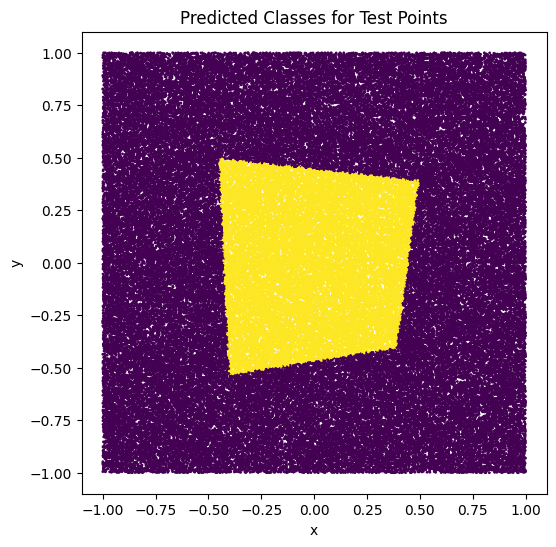

In [11]:

import numpy as np
import matplotlib.pyplot as plt

# Generate 10000 new points
n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

# Run the points through the network
with torch.no_grad():  # We don't need gradients for this part
    tmp = points_test_torch@W1 + b1
    tmp = F.relu(tmp)
    output_test = tmp@W2 + b2
    prob = torch.sigmoid(output_test)
pred = (0.5 < prob).numpy()

# Plot the points, colored by their predicted class
plt.figure(figsize=(6, 6))
plt.scatter(points_test[:, 0], points_test[:, 1], c=pred, cmap='viridis', s=1)
plt.title('Predicted Classes for Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()